## Requirements

To install all requirements, run the following cells:

In [1]:
%%writefile requirements.txt
certifi==2020.6.20
cycler==0.10.0
joblib==0.17.0
kiwisolver==1.3.1
matplotlib==3.3.3
numpy==1.19.4
pandas==1.1.4
Pillow==8.0.1
pyarrow==0.17.1
pyparsing==2.4.7
python-dateutil==2.8.1
pytz==2020.4
scikit-learn==0.23.2
scipy==1.5.4
seaborn==0.11.0
six==1.15.0
threadpoolctl==2.1.0
tqdm==4.53.0

Overwriting requirements.txt


In [2]:
!pip install -r requirements.txt

## Constants and settings

In [3]:
# drop all data that falls outside these ranges
BASE_CONSTRAINTS = (
    # excessive skewness
    ('sea_state_30m_skewness', -0.5, 0.5),
    
    # excessive low-frequency drift
    ('sea_state_30m_rel_energy_in_frequency_interval_1', 0, 0.1),    
)


# thresholds for rogue waves and crests (relative to SWH)
LABEL_THRESHOLDS = {
    'wave': (2.0, 2.4),
    'crest': (1.2, 1.5),
}


# Beta distribution prior parameters for each threshold
PRIOR_PARAMS = {
    'wave': {
        2.0: (10_000, 1),
        2.4: (1_000_000, 1),
    },
    'crest': {
        1.2: (10_000, 1),
        1.5: (1_000_000, 1),
    }
}

#'cp',
# FOWD features to include in analysis



TRAIN_FEATURES_WAVES = (
    'sea_state_30m_crest_trough_correlation',
    'sea_state_30m_peak_ursell_number_log10',
    'sea_state_30m_benjamin_feir_index_peakedness',
    'sea_state_30m_steepness',
    'sea_state_30m_skewness',
    'sea_state_30m_mean_period_spectral',
    'sea_state_30m_rel_energy_in_frequency_interval_2',
    'sea_state_30m_rel_energy_in_frequency_interval_1',
    'sea_state_30m_significant_wave_height_spectral',
    'sea_state_30m_peak_relative_depth_log10',
    'sea_state_30m_mean_period_spectral',
)



#'r$\beta_ang$'

#,dpi = 400

FEATURE_NAMES = {
    'sea_state_30m_crest_trough_correlation': 'Crest-trough correlation',
    'sea_state_30m_bandwidth_peakedness': 'Spectral bandwidth',
    'sea_state_30m_mean_period_spectral': 'Mean period',
    'sea_state_30m_rel_energy_in_frequency_interval_2': 'Rel. low-frequency energy',
    'direction_dominant_spread': 'Directional spread',
    'sea_state_30m_peak_ursell_number_log10': 'Ursell number ($\\log_{10}$)',
    'sea_state_30m_benjamin_feir_index_peakedness': 'Benjamin-Feir index',
    'sea_state_30m_kurtosis': 'Excess kurtosis',
    'sea_state_30m_steepness': 'Steepness',
    'sea_state_30m_significant_wave_height_spectral': 'Significant wave height',
    'sea_state_30m_skewness': 'Skewness',
    'sea_state_30m_peak_relative_depth_log10': 'Relative depth ($\\log_{10}$)',
    'sea_state_30m_robust_kurtosis_exceedance': 'Robust kurtosis (exceedance)',
    'sea_state_30m_robust_kurtosis_spread': 'Robust kurtosis (spread)',
    'WSPD': 'Wind speed',
    'WSPD_ang': ' Wind Speed(Ang)',
    'saturation_wave_height_ang': 'Saturation WHT(ang)',
    'wind_wave_misalignment': 'Wind wave misalignment',  
    'inverse_wave_age_ang': 'Inverse wave age(ang)',
    'inverse_wave_age':'Inverse wave age',
    'saturation_wave_height': 'Saturation WHT',
    'cp':'Phase velocity',
    'WDIR':'Wind Direction',
   
    
    
    
}





# 'saturation_wave_height_misalignment':'saturation wh misalignment',
# units
TRAIN_FEATURE_UNITS = {
    'sea_state_30m_significant_wave_height_spectral': '$\\,$m',
    'direction_dominant_spread': '$\\degree$',
    'sea_state_30m_mean_period_spectral': '$\\,$s',
    'WSPD': '$\\,$m/s',
    'U10_WSPD': '$\\,$m/s',
}

#'cp':(0, 30), 
#'saturation_wave_height':(0, 5.0),
#-2.0,2.0 wave_age.
# axis ranges for each feature


# For absolute features, replace negative value with 0
FEATURE_RANGES = {
    'direction_dominant_spread': (0, 90),
    'sea_state_30m_bandwidth_peakedness': (0, 0.6),
    'sea_state_30m_benjamin_feir_index_peakedness': (0, 0.6),
    'sea_state_30m_crest_trough_correlation': (0, 1),
    'sea_state_30m_kurtosis': (-0.5, 1.5),
    'sea_state_30m_mean_period_spectral': (4, 15),
    'sea_state_30m_peak_relative_depth_log10': (-1, 2),
    'sea_state_30m_peak_ursell_number_log10': (-3, 2.2),
    'sea_state_30m_rel_energy_in_frequency_interval_2': (0, 1),
    'sea_state_30m_significant_wave_height_spectral': (0.5, 8),
    'sea_state_30m_skewness': (-0.5, 0.5),
    'sea_state_30m_steepness': (0, 0.12),
    'WSPD':(0, 30.0),
    'WSPD_ang':(-20.0,20.0),
    'saturation_wave_height':(0, 4),
    'wind_wave_misalignment':(-1.0, 1.0), 
    'inverse_wave_age':(0, 2.0),
    'inverse_wave_age_ang':(-2.0, 2.0),
   
   

}


# feature to use for significant wave height
SWH_FEATURE = 'sea_state_30m_significant_wave_height_spectral'


# number of waves that are grouped together in aggregated data
AGGREGATE_FACTOR = 100


# names of target features
LABEL_FEATURES = (
    
    f'aggregate_{AGGREGATE_FACTOR}_max_rel_wave_height',
    f'aggregate_{AGGREGATE_FACTOR}_max_rel_crest_height',
)


# ratio of total data reserved for identifying clusters
# (rest is used to evaluate cluster statistics)
TRAIN_RATIO = 0.33







# set random state to ensure reproducibility
RANDOM_SEED = 17

## Helper functions

In [4]:
import os
import glob
import math

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm.notebook

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor

from matplotlib import colors
from matplotlib.ticker import LogLocator, NullFormatter

from scipy.stats import beta as beta_dist
from scipy.stats import gaussian_kde
from scipy.linalg import LinAlgError

sns.set_palette('muted')

random_state = np.random.RandomState(seed=RANDOM_SEED)

### Input

In [5]:

def is_aggregate(df):
    """Determine whether data is aggregated."""
    return 'aggregate_id_local' in df.index.names


def apply_constraints(df):
    """Remove all data violating BASE_CONSTRAINTS."""
    for feature, lower, upper in BASE_CONSTRAINTS:
        n_rows = df.shape[0]
        mask = np.ones(n_rows, dtype='bool')

        if lower is not None:
            mask &= df[feature] >= lower

        if upper is not None:
            mask &= df[feature] <= upper

        df = df[mask]
        rows_filtered = n_rows - df.shape[0]

    return df



def get_label_feature(df, label_type):
    """Get label feature name (different for aggregated data)."""
    
    feature = f'aggregate_{AGGREGATE_FACTOR}_max_rel_{label_type}_height'
    
    return feature


def get_label(feature, threshold):
    """Binarize feature using threshold."""
    y = feature > threshold
    num_pos = np.count_nonzero(y)
    pos_ratio = num_pos / y.size
    return y

### Univariate binning and predictive power

In [6]:
def correct_for_aggregation(p, inflation_factor):
    """Correct a rogue wave probability for data aggregation 
    to get rogue wave probability per wave."""
    if inflation_factor == 1:
        return p

    return 1 - (1 - p) ** (1 / inflation_factor)


def compute_p(n_pos, n_neg, prior_params, inflation_factor, min_n_pos=10):
    """Compute p and 95% credible interval from n_pos and n_neg
    (number of positive and negative measurements)."""
    alpha = n_pos + prior_params[1]
    beta = n_neg + prior_params[0] / inflation_factor
    p_pdf = beta_dist(alpha, beta)
    
    def postprocess(p):
        mask = n_pos < min_n_pos
        p = np.where(mask, np.nan, p)
        return correct_for_aggregation(p, inflation_factor)

    p_median = postprocess(p_pdf.median())
    p_95 = [postprocess(p_pdf.ppf(q)) for q in (0.025, 0.975)]
    
    return (p_median, p_95)

In [7]:
def compute_predictive_power(pos_1, neg_1, pos_2, neg_2, prior_params, num_samples=10**5, inflation_factor=100):
    """Compute predictive power log_10(b2 / b1) for Beta distributed b2, b1."""
    samples = [
        correct_for_aggregation(
            beta_dist(n_pos + prior_params[1] , n_neg + prior_params[0] / inflation_factor).rvs(num_samples), 
            inflation_factor
        )
        for n_pos, n_neg in ((pos_1, neg_1), (pos_2, neg_2))
    ]
    pred_power = np.log10(samples[1] / samples[0])

    return dict(
        median=np.median(pred_power, axis=0),
        p95=np.quantile(pred_power, [0.025, 0.975], axis=0)
    )

In [8]:
def get_binned_p(X, y, prior_params, inflation_factor=100, n_bins=13):
    """Run univariate bin analysis on all columns of X using labels y."""
    X_pos = X[y == 1]
    X_neg = X[y == 0]

    out = {}

    for feature in X.columns:
        frange = FEATURE_RANGES.get(feature)
        if frange is None:
            fmin = X[feature].quantile(1e-5)
            fmax = X[feature].quantile(1 - 1e-5)
        else:
            fmin, fmax = frange

        bins = np.concatenate([
            [-np.inf], np.linspace(fmin, fmax, n_bins + 1), [np.inf]
        ])
        hist_pos, _ = np.histogram(X_pos[feature], bins=bins)
        hist_neg, _ = np.histogram(X_neg[feature], bins=bins)
        
        p_median, p_95 = compute_p(hist_pos, hist_neg, prior_params, inflation_factor)
        
        maxsig = np.nanargmax(p_median)
        minsig = np.nanargmin(p_median)
        
        pred_power = compute_predictive_power(
            hist_pos[minsig], hist_neg[minsig], hist_pos[maxsig], hist_neg[maxsig], 
            prior_params=prior_params, inflation_factor=inflation_factor
        )

        out[feature] = dict(
            bins=bins,
            n_samples=(hist_pos + hist_neg),
            p_median=p_median,
            p_95=p_95,
            pred_power_median=pred_power['median'],
            pred_power_p95=pred_power['p95'],
        )

    return out


def get_minsig_maxsig(p_out):
    """Get maximum lower bound and minimum upper bound p from output of get_binned_p"""
    minsig = np.nanmin([
        pdict['p_95'][1]
        for pdict in p_out.values()
    ])
    maxsig = np.nanmax([
        pdict['p_95'][0]
        for pdict in p_out.values()
    ])
    return minsig, maxsig

In [9]:
def tayfun_cdf(r, h):
    """Tayfun CDF in terms of h = H / H_S.
    
    As given in 
    
        Tayfun, M. Aziz, and Francesco Fedele. “Wave-Height Distributions and Nonlinear Effects.” 
        Ocean Engineering, vol. 34, no. 11, Aug. 2007, pp. 1631–49. 
        ScienceDirect, doi:10.1016/j.oceaneng.2006.11.006.

    """
    h_rms = 4 * h
    return (
        np.sqrt((1 + r) / (2 * r))
        * (1 + (1 - r**2) / (4 * r * h_rms**2))
        * np.exp(-1 / (4 * (1 + r)) * h_rms**2)
    )


def unit_formatter(unit, max_precision=6):
    """Custom formatter to use for quantities with units."""
    from functools import partial
    return partial(lambda x, pos, u: f'{round(x, max_precision)}{u}', u=unit)




# Importing the combined datasets of wind and FOWD data

In [10]:
constraint_features = [f for f, _, _ in BASE_CONSTRAINTS]
extra_features=constraint_features

TRAIN_FEATURES_NEW_WIND = (
    'WSPD',
    'WSPD_ang',
    'saturation_wave_height_ang',
    'saturation_wave_height',
    'wind_wave_misalignment',  
    'inverse_wave_age_ang',
    'inverse_wave_age',
    
)



#all_columns = set(list(TRAIN_FEATURES_WAVES) + list(LABEL_FEATURES)+ list([SWH_FEATURE])+list(extra_features))

all_columns_new = set(list(TRAIN_FEATURES_WAVES) +list(TRAIN_FEATURES_NEW_WIND)+list(LABEL_FEATURES)+ list([SWH_FEATURE])+list(extra_features))


df_036=pd.read_parquet('C:/Users/yulii/Downloads/df_036', columns=all_columns_new)


df_162=pd.read_parquet('C:/Users/yulii/Downloads/df_162', columns=all_columns_new)
df_147=pd.read_parquet('C:/Users/yulii/Downloads/df_147', columns=all_columns_new)
df_156=pd.read_parquet('C:/Users/yulii/Downloads/df_156', columns=all_columns_new)


df_107=pd.read_parquet('C:/Users/yulii/Downloads/df_107', columns=all_columns_new)
df_168=pd.read_parquet('C:/Users/yulii/Downloads/df_168', columns=all_columns_new)
df_171=pd.read_parquet('C:/Users/yulii/Downloads/df_171', columns=all_columns_new)


df_179=pd.read_parquet('C:/Users/yulii/Downloads/df_179', columns=all_columns_new)
df_142=pd.read_parquet('C:/Users/yulii/Downloads/df_142', columns=all_columns_new)
df_185=pd.read_parquet('C:/Users/yulii/Downloads/df_185', columns=all_columns_new)

df_227=pd.read_parquet('C:/Users/yulii/Downloads/df_227', columns=all_columns_new)
df_234=pd.read_parquet('C:/Users/yulii/Downloads/df_234', columns=all_columns_new)


df_128=pd.read_parquet('C:/Users/yulii/Downloads/df_128', columns=all_columns_new)
df_180=pd.read_parquet('C:/Users/yulii/Downloads/df_180', columns=all_columns_new)
df_235=pd.read_parquet('C:/Users/yulii/Downloads/df_235', columns=all_columns_new)
#df_230=pd.read_parquet('C:/Users/yulii/Downloads/df_230', columns=all_columns_new)

2736
16
6384
133
673017
0.009485644493378324
Index(['WSPD', 'inverse_wave_age', 'WSPD_ang',
       'sea_state_30m_rel_energy_in_frequency_interval_2',
       'sea_state_30m_peak_relative_depth_log10', 'sea_state_30m_steepness',
       'sea_state_30m_rel_energy_in_frequency_interval_1',
       'wind_wave_misalignment', 'saturation_wave_height',
       'sea_state_30m_peak_ursell_number_log10', 'saturation_wave_height_ang',
       'aggregate_100_max_rel_crest_height',
       'sea_state_30m_benjamin_feir_index_peakedness',
       'sea_state_30m_significant_wave_height_spectral',
       'sea_state_30m_crest_trough_correlation',
       'aggregate_100_max_rel_wave_height', 'sea_state_30m_skewness', 'WDIR',
       'sea_state_30m_mean_period_spectral', 'inverse_wave_age_ang'],
      dtype='object')


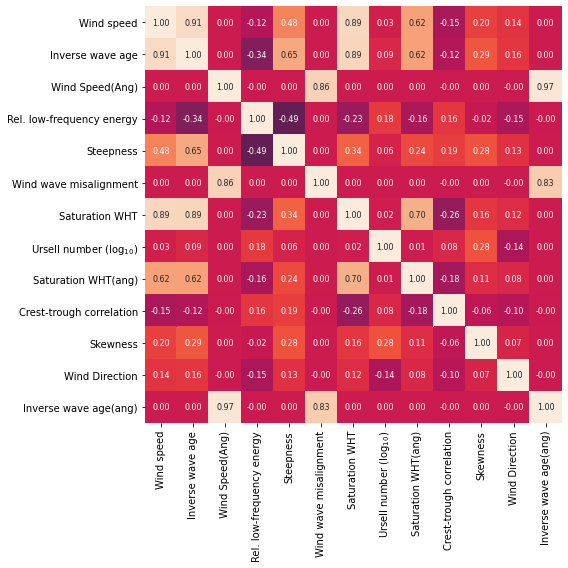

In [11]:


df = pd.concat([df_235, df_180, df_128, df_036, df_107, df_168, df_171, df_179, df_142, df_185, df_227, df_234, df_162, df_147, df_156],copy=False)
#230
df = apply_constraints(df)
df = df.dropna()



X = df.drop(columns = ['aggregate_100_max_rel_wave_height','aggregate_100_max_rel_crest_height','sea_state_30m_mean_period_spectral','sea_state_30m_rel_energy_in_frequency_interval_1','sea_state_30m_peak_relative_depth_log10','sea_state_30m_benjamin_feir_index_peakedness','sea_state_30m_significant_wave_height_spectral'])

corr = X.corr('pearson')



fig = plt.figure(figsize=(10, 8))

sns.heatmap(
    corr, annot=True, vmin=-1, vmax=1, cbar=False, fmt='.2f', annot_kws=dict(fontsize=8),
    xticklabels=[FEATURE_NAMES[f] for f in X.columns], yticklabels=[FEATURE_NAMES[f] for f in X.columns], square=True
)
fig.tight_layout()
plt.savefig('correlation-matrix.pdf', bbox_inches='tight')
print(len(df[(df['aggregate_100_max_rel_crest_height'] >= 1.2)]))
print(len(df[(df['aggregate_100_max_rel_crest_height'] >= 1.5)]))
print(len(df[(df['aggregate_100_max_rel_wave_height'] >= 2.0)]))
print(len(df[(df['aggregate_100_max_rel_wave_height'] >= 2.4)]))
print(len(df))
print(len(df[(df['aggregate_100_max_rel_wave_height'] >= 2.0)])/len(df))
print(df.columns)



In [12]:



wave_type = 'wave'

label_feature = get_label_feature(df, wave_type)
thresh_low, thresh_high = LABEL_THRESHOLDS[wave_type]
priors = PRIOR_PARAMS[wave_type]









y_low = (df['aggregate_100_max_rel_wave_height'] > 2.0)
y_high = (df['aggregate_100_max_rel_wave_height'] > 2.4)



def convert(list):
    return tuple(list)
TRAIN_FEATURES_NEW = convert(X.columns.values.tolist())

TRAIN_FEATURES_NEW_WAVE = (
    'WSPD',
    'U10_WSPD',
    'saturation_wave_height_U10',
    'wind_wave_misalignment',  
    'inverse_wave_age_U10',
    'inverse_wave_age',
    'saturation_wave_height',                     
                        
)





def plot_binned_p(ps, labels, fac=None, features=TRAIN_FEATURES_NEW, units=TRAIN_FEATURE_UNITS, plot_tayfun=True, thresholds=None):
    """Plot a list of binned p (as obtained via get_binned_p) with confidence intervals."""

    if plot_tayfun and thresholds is None:
        raise ValueError('Thresholds must be given to compute Tayfun distribution')

    num_cols = 3
    num_rows = math.ceil(len(features) / num_cols)
    
    if units is None:
        units = {}
        
    if isinstance(ps, dict):
        ps = [ps]
        
    if fac is None:
        fac = (1,) * len(ps)

    fig = plt.figure(figsize=(6, 1.8 * num_rows))
    gs = fig.add_gridspec(num_rows + 1, num_cols, height_ratios=[1] * num_rows + [0.05])

    legend_handles = []
    tayfun_handle = None
    first = True

    for i, feature in enumerate(features):
        ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
        for j, p_all in enumerate(ps):
            p = p_all[feature]
            color = f'C{j}'

            bin_centers = 0.5 * (p['bins'][1:] + p['bins'][:-1])
            bin_centers[0] = 2 * bin_centers[1] - bin_centers[2]
            bin_centers[-1] = 2 * bin_centers[-2] - bin_centers[-3]

            c_rgb = list(colors.to_rgba(color)[:-1])

            h = ax.fill_between(
                bin_centers, p['p_95'][1] * fac[j], p['p_95'][0] * fac[j], linewidth=1,
                edgecolor=c_rgb + [1.0], facecolor=c_rgb + [0.6], clip_on=False, zorder=10,
            )

            if first:
                legend_handles.append(h)

            if not np.any(np.isfinite(p['p_95'])):
                continue

            if plot_tayfun and 'crest_trough_correlation' in feature:
                # plot Tayfun CDF
                h, = ax.plot(
                    bin_centers,
                    tayfun_cdf(r=bin_centers, h=thresholds[j]) * fac[j],
                    c=color, linestyle='dashed', alpha=0.8
                )
                if tayfun_handle is None:
                    tayfun_handle = h

        first = False

        ax.set_xlim(bin_centers[0], bin_centers[-1])

        ax.set_yscale('log')
        ax.set_ylim(5e-6, 5e-4)
        ax.set_yticks([1e-5, 1e-4])
        
        if i % num_cols == 0:
            ax.spines['left'].set_position(('outward', 5))
            locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=12) 
            ax.yaxis.set_minor_locator(locmin)
            ax.yaxis.set_minor_formatter(NullFormatter())
            ax.set_ylabel('p')
        else:
            ax.spines['left'].set_visible(False)
            ax.set_yticklabels([])
            ax.yaxis.set_ticks_position('none') 

        ax.spines['bottom'].set_position(('outward', 5))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        ax.grid(b=True, which='major', axis='y', color='0.4', linestyle='dashed')

        title = FEATURE_NAMES[feature]
        ax.set_title(title, fontsize=10)
        
        if feature in units:
            ax.xaxis.set_major_formatter(unit_formatter(units[feature]))

    ax = fig.add_subplot(gs[-1, :], frame_on=False, xticks=[], yticks=[])
    
    if tayfun_handle is not None:
        legend_handles += [tayfun_handle]
        labels += ['Tayfun CDF']
    
    ax.legend(legend_handles + [tayfun_handle], labels, loc='center', frameon=False, ncol=6)

    fig.tight_layout(h_pad=2, w_pad=1)
def plot_predictive_power(ps, labels, min_cval=0, max_cval=1, legend_title=None):
    """Plots predictive power of each parameter."""
    if isinstance(ps, dict):
        ps = [ps]

    fig, ax = plt.subplots(1, 1, figsize=(6.0, 7.4))

    handles = [None] * len(ps)
    
    color_offset = 0.4
    
    features = TRAIN_FEATURES_NEW[::-1]

    for i, feature in enumerate(features):
        for j, p in enumerate(ps):
            p = p[feature]         
            
            cmap = sns.dark_palette(f'C{j}', as_cmap=True)
            color = cmap(
                color_offset + (1 - color_offset) * (p['pred_power_p95'][0] - min_cval) / (max_cval - min_cval)
            )

            xerr = p['pred_power_p95'][1] - p['pred_power_p95'][0] 
            handles[j] = ax.errorbar(
                p['pred_power_p95'][0], i - 0.25 * (j - 0.5), 
                fmt='d', xerr=np.abs(xerr), color=color, xlolims=True, 
                ecolor=(0.6, 0.6, 0.6, 1),
            )

    ax.set_xticks([0, 0.25, 0.5, 0.75,  1.0])
    ax.tick_params(axis='x', labelsize=9)

    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(
        [FEATURE_NAMES[f] for f in features],
        fontsize=9
    )

    for spine in ('left', 'right', 'bottom', 'top'):
        ax.spines[spine].set_visible(False)

    ax.set_xlabel('Univariate predictive power', fontsize=9)
    
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.grid(b=True, which='major', axis='x', color='0.8', linestyle='dashed')
    
    fig.tight_layout()
    
    plt.subplots_adjust(bottom=0.15)
    fig.legend(
        handles, labels, loc='lower center', title=legend_title, 
        fontsize='small', edgecolor='none', title_fontsize='small',
        ncol=3,
    )




In [13]:
p_low = get_binned_p(
    X, y_low, priors[thresh_low], inflation_factor=100
)
p_high = get_binned_p(
    X, y_high, priors[thresh_high], inflation_factor=100
)


<ipython-input-9-60b35ec7f347>:13: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt((1 + r) / (2 * r))
<ipython-input-9-60b35ec7f347>:13: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt((1 + r) / (2 * r))


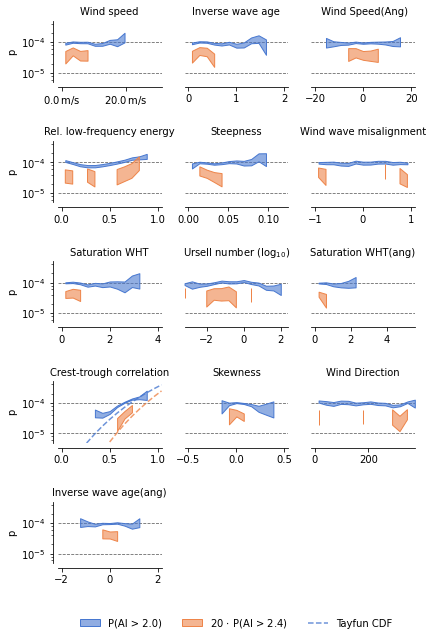

In [14]:
plot_binned_p(
    [p_low, p_high], 
    [f'P(AI > {thresh_low})', f'20 $\\cdot$ P(AI > {thresh_high})'], 
    fac=[1, 20],
    thresholds=[thresh_low, thresh_high],
)
plt.savefig('p-univariate-all.pdf')







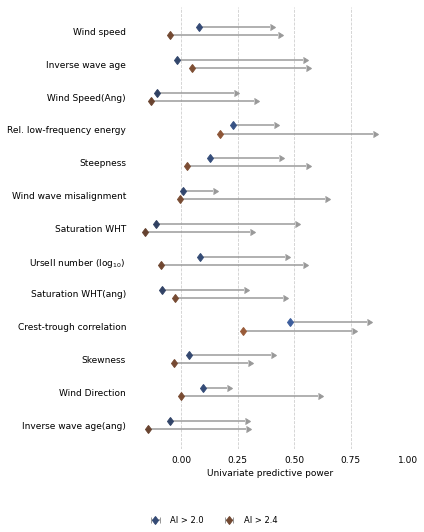

In [15]:
plot_predictive_power((p_low, p_high), ['AI > 2.0', 'AI > 2.4'])
plt.savefig('pred-power-all.pdf')

In [16]:

wave_type = 'wave'

label_feature = get_label_feature(df, wave_type)
thresh_low, thresh_high = LABEL_THRESHOLDS[wave_type]
priors = PRIOR_PARAMS[wave_type]


#### Stratify by crest-trough correlation

In [17]:
ctc_bins = [(0.6, 0.65), (0.4, 0.5), (0.7, 0.8)]
ctc_labels = [f'{name} ({low}-{up})' for name, (low, up) in zip(('peak', 'low', 'high'), ctc_bins)]

In [18]:
ctc_p = []

for lower, upper in ctc_bins:
    mask = (
        (X['sea_state_30m_crest_trough_correlation'] < upper) 
        & (X['sea_state_30m_crest_trough_correlation'] > lower)
    )
    ctc_p.append(get_binned_p(
        X[mask],
        y_low[mask],
        priors[thresh_low],
        inflation_factor=100
    ))

In [19]:
# print all parameters that still have some predictive power
for label, p in zip(ctc_labels, ctc_p):
    for feature, vals in sorted(p.items(), key=lambda v: v[1]['pred_power_p95'][0], reverse=True):
        if vals['pred_power_p95'][0] > 0.1 or feature == 'sea_state_30m_bandwidth_peakedness':
            print(label, feature, vals['pred_power_p95'][0])

peak (0.6-0.65) sea_state_30m_peak_ursell_number_log10 0.12113202190724104
low (0.4-0.5) sea_state_30m_rel_energy_in_frequency_interval_2 0.1417173161615346
low (0.4-0.5) WSPD 0.13167147184682731
high (0.7-0.8) inverse_wave_age 0.14123283821884983


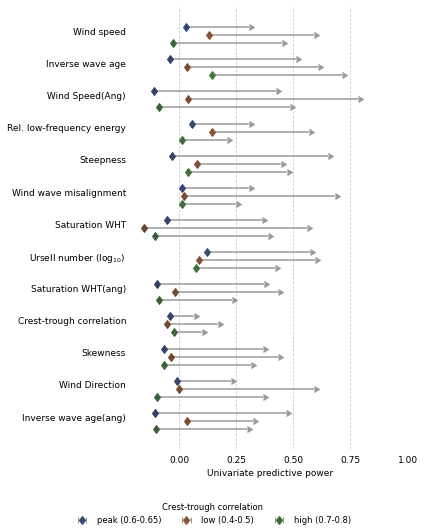

In [20]:
plot_predictive_power(ctc_p, ctc_labels, legend_title='Crest-trough correlation')
plt.savefig('pred-power-ctc.pdf', bbox_inches='tight')

peak (0.6-0.65) sea_state_30m_peak_ursell_number_log10 0.12113202190724104
low (0.4-0.5) sea_state_30m_rel_energy_in_frequency_interval_2 0.1417173161615346
low (0.4-0.5) WSPD 0.13167147184682731
high (0.7-0.8) inverse_wave_age 0.14123283821884983


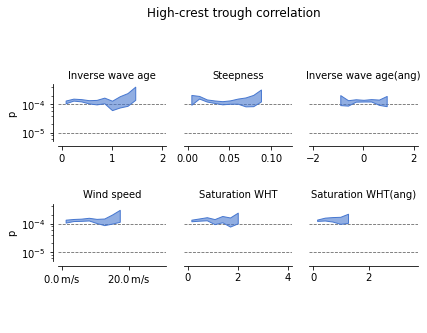

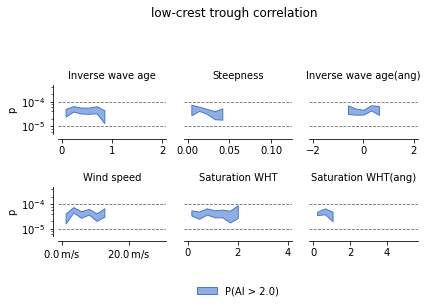

In [21]:


feature_subset = [ 
    'inverse_wave_age',
    'sea_state_30m_steepness',
    'inverse_wave_age_ang',
    'WSPD',
    'saturation_wave_height',
    'saturation_wave_height_ang',
   
]



plot_binned_p(
    ctc_p[2], [f'P(AI > {thresh_low})'], 
    features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.gca().get_legend().remove()
plt.suptitle('High-crest trough correlation', y=1.3, x=0.55)
plt.subplots_adjust(top=1)
plt.savefig('high_ctc.pdf', bbox_inches='tight')    

plot_binned_p(
    ctc_p[1], [f'P(AI > {thresh_low})'], 
    features=feature_subset, plot_tayfun=False, fac=[1, 20]
)

plt.suptitle('low-crest trough correlation', y=0.9, x=0.55)
plt.subplots_adjust(top=0.6, bottom=-0.2)
plt.savefig('low_ctc.pdf')



for label, p in zip(ctc_labels, ctc_p):
    for feature, vals in sorted(p.items(), key=lambda v: v[1]['pred_power_p95'][0], reverse=True):
        if vals['pred_power_p95'][0] > 0.1:
            print(label, feature, vals['pred_power_p95'][0])

      

# Inverse wave age

peak (0.4-0.7) sea_state_30m_crest_trough_correlation 0.3867510240762577
peak (0.4-0.7) sea_state_30m_rel_energy_in_frequency_interval_2 0.1649958705123263
peak (0.4-0.7) WDIR 0.11937744481494553
peak (0.4-0.7) sea_state_30m_peak_ursell_number_log10 0.1088743839696267
high (1.0-1.3) sea_state_30m_steepness 0.1854116703130591
high (1.0-1.3) sea_state_30m_crest_trough_correlation 0.13407334696861475
low (0.0-0.3) sea_state_30m_crest_trough_correlation 0.47885968394466266
low (0.0-0.3) sea_state_30m_rel_energy_in_frequency_interval_2 0.1938378120790079
low (0.0-0.3) sea_state_30m_peak_ursell_number_log10 0.1346491301742954


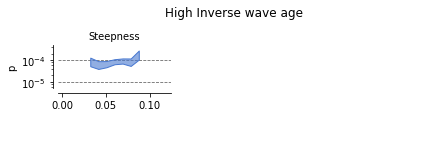

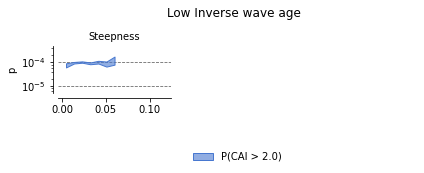

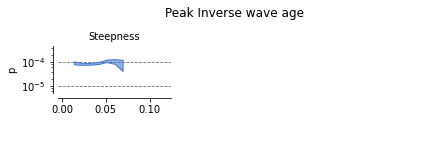

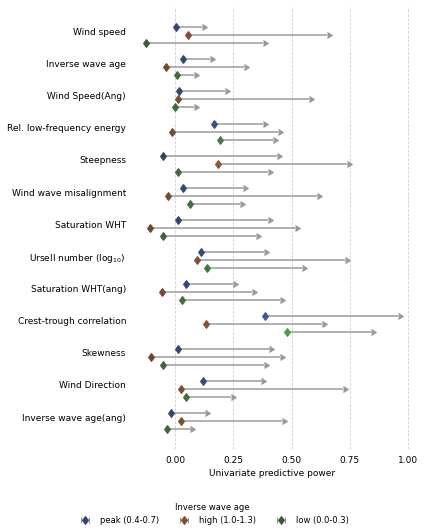

In [22]:

inv_bins = [(0.4, 0.7), (1.0, 1.3), (0.0, 0.3)]
#Z = df[['WSPD','inverse_wave_age_U10','inverse_wave_age','sea_state_30m_steepness']]
inv_p = []

for lower, upper in inv_bins:
    mask = (
        (X['inverse_wave_age'] < upper) 
        & (X['inverse_wave_age'] > lower)
    )
    inv_p.append((
        get_binned_p(
            X[mask],
            y_low[mask],
            priors[thresh_low],
            inflation_factor=100
        )
    ))






feature_subset = [
    'sea_state_30m_steepness',
]

plot_binned_p(
    inv_p[1], [f'P(CAI > {thresh_low})'],features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.gca().get_legend().remove()
plt.suptitle('High Inverse wave age', y=0.9, x=0.55)
plt.subplots_adjust(top=0.6, bottom=-0.2)
plt.savefig('High Inverse wave age.pdf')

plot_binned_p(
    inv_p[2], [f'P(CAI > {thresh_low})'], 
    features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.suptitle('Low Inverse wave age', y=1.3, x=0.55)
plt.subplots_adjust(top=1)
plt.savefig('low Inverse wave age.pdf', bbox_inches='tight')    


plot_binned_p(
    inv_p[0], [f'P(CAI > {thresh_low})'], 
    features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.gca().get_legend().remove()
plt.suptitle('Peak Inverse wave age', y=1.3, x=0.55)
plt.subplots_adjust(top=1)
plt.savefig('peak Inverse wave age.pdf', bbox_inches='tight')  


inv_labels = [f'{name} ({low}-{up})' for name, (low, up) in zip(('peak', 'high', 'low'), inv_bins)]

for label, p in zip(inv_labels, inv_p):
    for feature, vals in sorted(p.items(), key=lambda v: v[1]['pred_power_p95'][0], reverse=True):
        if vals['pred_power_p95'][0] > 0.1:
            print(label, feature, vals['pred_power_p95'][0])

plot_predictive_power(inv_p, inv_labels, legend_title='Inverse wave age')
plt.savefig('predpower_inv_wave_age.pdf', bbox_inches='tight') 


# Stratifying on steepness

peak (0.03-0.04) sea_state_30m_crest_trough_correlation 0.31415483566082514
peak (0.03-0.04) sea_state_30m_peak_ursell_number_log10 0.14902518823134786
peak (0.03-0.04) saturation_wave_height 0.13192211392340034
high (0.05-0.08) sea_state_30m_crest_trough_correlation 0.11855168581420648
low (0.0-0.03) sea_state_30m_crest_trough_correlation 0.45676912096359434
low (0.0-0.03) sea_state_30m_rel_energy_in_frequency_interval_2 0.28144895039274254
low (0.0-0.03) WDIR 0.13344856972142147


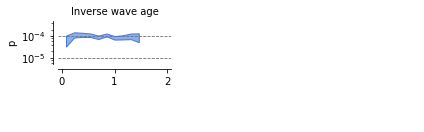

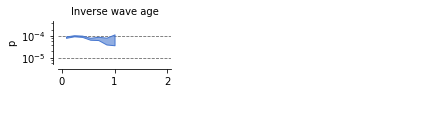

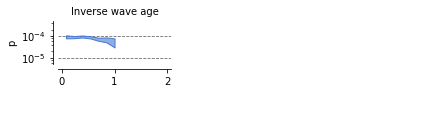

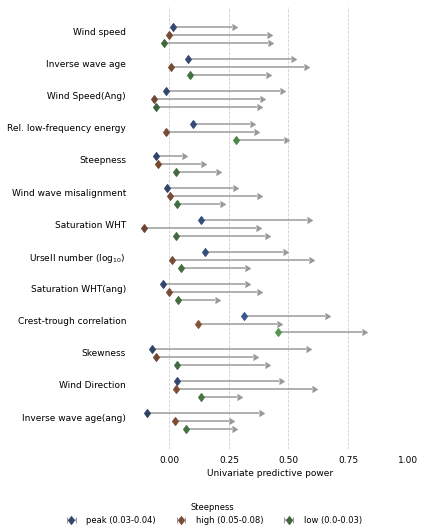

In [23]:
steep_bins = [(0.03, 0.04), (0.05, 0.08), (0.0, 0.03)]
#Z = df[['WSPD','inverse_wave_age_U10','inverse_wave_age','sea_state_30m_steepness']]
steep_p = []


for lower, upper in steep_bins:
    mask = (
        (X['sea_state_30m_steepness'] < upper) 
        & (X['sea_state_30m_steepness'] > lower)
    )
    steep_p.append((
        get_binned_p(
            X[mask],
            y_low[mask],
            priors[thresh_low],
            inflation_factor=100
        )
    ))






feature_subset = [
    'inverse_wave_age',
   
]

plot_binned_p(
    steep_p[1], [f'P(CAI > {thresh_low})'],features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.gca().get_legend().remove()
#plt.suptitle('High Steepness', ha = 'right', va = 'top')
plt.subplots_adjust(top=0.6, bottom=-0.2)
plt.savefig('High steepness.pdf', bbox_inches='tight', transparent = True)

plot_binned_p(
    steep_p[2], [f'P(CAI > {thresh_low})'], 
    features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.gca().get_legend().remove()
#plt.suptitle('Low Steepness', ha = 'left', va = 'top')
plt.subplots_adjust(top=0.6, bottom=-0.2)
plt.savefig('low-steepness.pdf', bbox_inches='tight', transparent = True)    


plot_binned_p(
    steep_p[0], [f'P(CAI > {thresh_low})'], 
    features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.gca().get_legend().remove()
#plt.suptitle('Peak Steepness', ha = 'left', va = 'top')
plt.subplots_adjust(top=0.6, bottom=-0.2)
plt.savefig('peak-Steepness.pdf', bbox_inches='tight', transparent = True)  


steep_labels = [f'{name} ({low}-{up})' for name, (low, up) in zip(('peak', 'high', 'low'), steep_bins)]

for label, p in zip(steep_labels, steep_p):
    for feature, vals in sorted(p.items(), key=lambda v: v[1]['pred_power_p95'][0], reverse=True):
        if vals['pred_power_p95'][0] > 0.1:
            print(label, feature, vals['pred_power_p95'][0])

plot_predictive_power(steep_p, steep_labels, legend_title='Steepness')
plt.savefig('predpower_steep.pdf', bbox_inches='tight') 

# Stratisfying on energy

number of rogue waves 133
peak (0.4-0.5) sea_state_30m_crest_trough_correlation 0.21583464114487227
peak (0.4-0.5) WSPD 0.17212847222391686
peak (0.4-0.5) saturation_wave_height 0.1349157429283904
peak (0.4-0.5) sea_state_30m_peak_ursell_number_log10 0.1335566119953065
high (0-0.1) inverse_wave_age 0.22030595448290272
high (0-0.1) WDIR 0.1361978210210785
high (0-0.1) sea_state_30m_steepness 0.10308059040196557
low (0.8-0.85) wind_wave_misalignment 0.1548651742941659


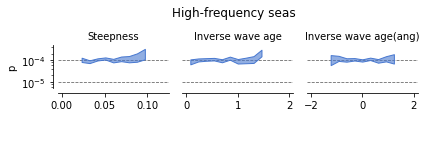

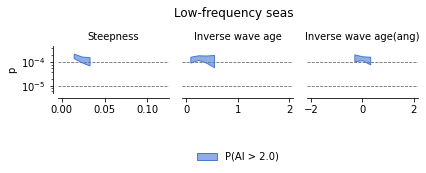

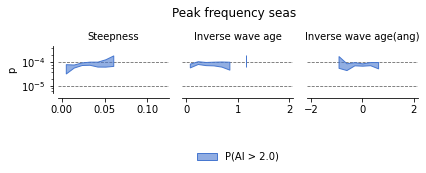

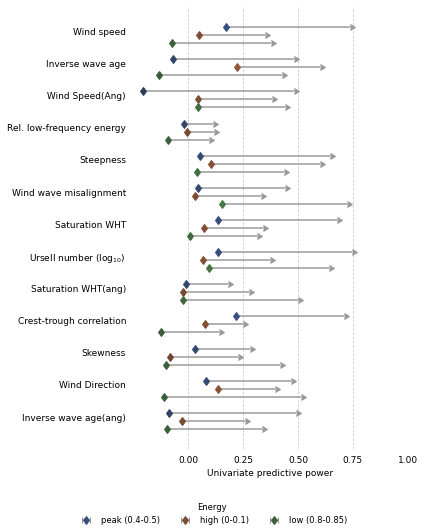

In [24]:
energy_bins = [(0.4, 0.5), (0, 0.1), (0.8, 0.85)]

energy_p = []
print('number of rogue waves',len(y_high[y_high == 1]))
for lower, upper in energy_bins:
    mask = (
        (X['sea_state_30m_rel_energy_in_frequency_interval_2'] < upper) 
        & (X['sea_state_30m_rel_energy_in_frequency_interval_2'] > lower)
    )
    energy_p.append((
        get_binned_p(
            X[mask],
            y_low[mask],
            priors[thresh_low],
            inflation_factor=100
        )
    ))






feature_subset = [
    'sea_state_30m_steepness', 
    'inverse_wave_age',
    'inverse_wave_age_ang'
   
]

plot_binned_p(
    energy_p[1], [f'P(AI > {thresh_low})'], 
    features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.gca().get_legend().remove()
plt.suptitle('High-frequency seas', y=0.9, x=0.55)
plt.subplots_adjust(top=0.6, bottom=-0.2)
plt.savefig('p-high-freq.pdf')

plot_binned_p(
    energy_p[2], [f'P(AI > {thresh_low})'], 
    features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.suptitle('Low-frequency seas', y=1.3, x=0.55)
plt.subplots_adjust(top=1)
plt.savefig('p-low-freq.pdf', bbox_inches='tight')    

plot_binned_p(
    energy_p[0], [f'P(AI > {thresh_low})'], 
    features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.suptitle('Peak frequency seas', y=1.3, x=0.55)
plt.subplots_adjust(top=1)
plt.savefig('p-peak-freq.pdf', bbox_inches='tight')   

energy_labels = [f'{name} ({low}-{up})' for name, (low, up) in zip(('peak', 'high', 'low'), energy_bins)]

for label, p in zip(energy_labels, energy_p):
    for feature, vals in sorted(p.items(), key=lambda v: v[1]['pred_power_p95'][0], reverse=True):
        if vals['pred_power_p95'][0] > 0.1:
            print(label, feature, vals['pred_power_p95'][0])

plot_predictive_power(energy_p, energy_labels, legend_title='Energy')
plt.savefig('pred-power-Energy.pdf', bbox_inches='tight')        

# Rogue Crests

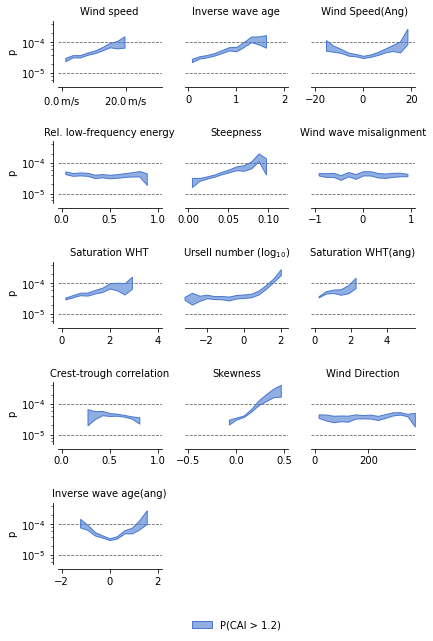

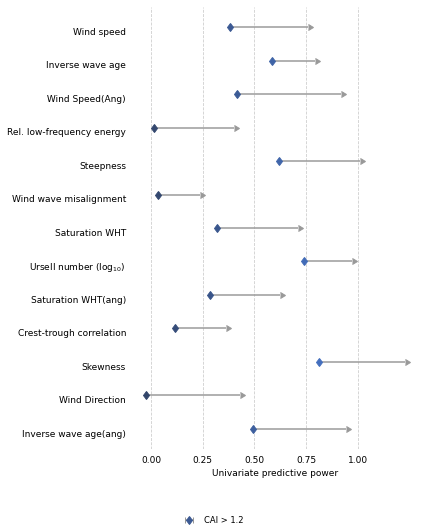

In [25]:


wave_type = 'crest'

label_feature = get_label_feature(df, wave_type)
thresh_low, thresh_high = LABEL_THRESHOLDS[wave_type]
priors = PRIOR_PARAMS[wave_type]


y_low = (df['aggregate_100_max_rel_crest_height'] > 1.2)
y_high = (df['aggregate_100_max_rel_crest_height'] > 1.5)



# compute binary labels

p_low = get_binned_p(
    X, y_low, priors[thresh_low], inflation_factor=100
)


plot_binned_p(
    [p_low], 
    [f'P(CAI > {thresh_low})'], 
    plot_tayfun=False, fac=[1, 50]
)
plt.savefig('p-crest-all.pdf')

plot_predictive_power((p_low), ['CAI > 1.2'])
plt.savefig('pred-power-crest-all.pdf')

# Stratification on Inverse wave age


peak (0.4-0.7) sea_state_30m_peak_ursell_number_log10 0.6420551701785169
peak (0.4-0.7) sea_state_30m_skewness 0.5846512707132486
peak (0.4-0.7) saturation_wave_height 0.2035079001734459
peak (0.4-0.7) WDIR 0.1297397484728569
high (1.0-1.3) sea_state_30m_peak_ursell_number_log10 0.21365885658805964
high (1.0-1.3) sea_state_30m_skewness 0.17523414154534206
high (1.0-1.3) sea_state_30m_steepness 0.1257898989745051
low (0.0-0.3) sea_state_30m_peak_ursell_number_log10 0.6557457467371838
low (0.0-0.3) sea_state_30m_skewness 0.450326218361946


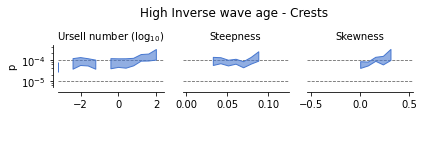

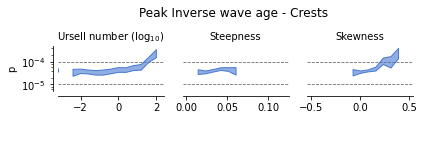

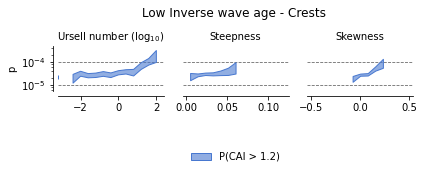

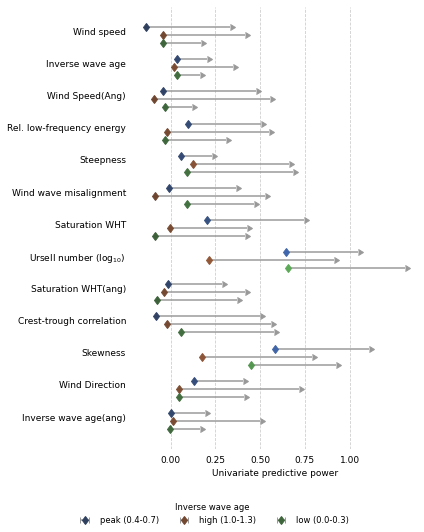

In [26]:
inv_bins = [(0.4, 0.7), (1.0,1.3), (0.0, 0.3)]
#Z = df[['WSPD','inverse_wave_age_U10','inverse_wave_age','sea_state_30m_steepness']]
inv_p = []

for lower, upper in inv_bins:
    mask = (
        (X['inverse_wave_age'] < upper) 
        & (X['inverse_wave_age'] > lower)
    )
    inv_p.append((
        get_binned_p(
            X[mask],
            y_low[mask],
            priors[thresh_low],
            inflation_factor=100
        )
    ))






feature_subset = [
    'sea_state_30m_peak_ursell_number_log10',
    'sea_state_30m_steepness',
    'sea_state_30m_skewness',
    
   
]

plot_binned_p(
    inv_p[1], [f'P(CAI > {thresh_low})'],features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.gca().get_legend().remove()
plt.suptitle('High Inverse wave age - Crests', y=0.9, x=0.55)
plt.subplots_adjust(top=0.6, bottom=-0.2)
plt.savefig('High Inverse wave age - beta- Crests.pdf')

plot_binned_p(
    inv_p[0], [f'P(CAI > {thresh_low})'], 
    features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.gca().get_legend().remove()
plt.suptitle('Peak Inverse wave age - Crests', y=1.3, x=0.55)
plt.subplots_adjust(top=1)
plt.savefig('peak Inverse wave age - beta- Crests.pdf', bbox_inches='tight')  

plot_binned_p(
    inv_p[2], [f'P(CAI > {thresh_low})'], 
    features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.suptitle('Low Inverse wave age - Crests', y=1.3, x=0.55)
plt.subplots_adjust(top=1)
plt.savefig('low Inverse wave age - beta- Crests.pdf', bbox_inches='tight')    





inv_labels = [f'{name} ({low}-{up})' for name, (low, up) in zip(('peak', 'high', 'low'), inv_bins)]

for label, p in zip(inv_labels, inv_p):
    for feature, vals in sorted(p.items(), key=lambda v: v[1]['pred_power_p95'][0], reverse=True):
        if vals['pred_power_p95'][0] > 0.1:
            print(label, feature, vals['pred_power_p95'][0])

plot_predictive_power(inv_p, inv_labels, legend_title='Inverse wave age')
plt.savefig('predpower_inv_wave_age_crests.pdf', bbox_inches='tight') 

# Stratification on Skewness

Low (0.0-0.1) inverse_wave_age 0.3655898009453701
Low (0.0-0.1) sea_state_30m_steepness 0.36005797802528666
Low (0.0-0.1) WSPD 0.25912760768125953
Low (0.0-0.1) saturation_wave_height 0.2317472412913329
Low (0.0-0.1) sea_state_30m_crest_trough_correlation 0.22933871295755062
Low (0.0-0.1) WSPD_ang 0.17726210597349584
Low (0.0-0.1) sea_state_30m_peak_ursell_number_log10 0.16031201950363225
Low (0.0-0.1) WDIR 0.13298195977193114
Low (0.0-0.1) inverse_wave_age_ang 0.10422251548049687
High (0.2-0.4) WDIR 0.28343581854638084
High (0.2-0.4) inverse_wave_age_ang 0.22707133724617393
High (0.2-0.4) WSPD_ang 0.17806168048337126
High (0.2-0.4) sea_state_30m_peak_ursell_number_log10 0.12449933070588788


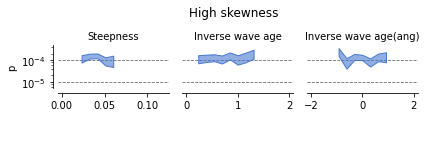

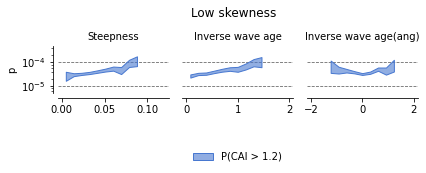

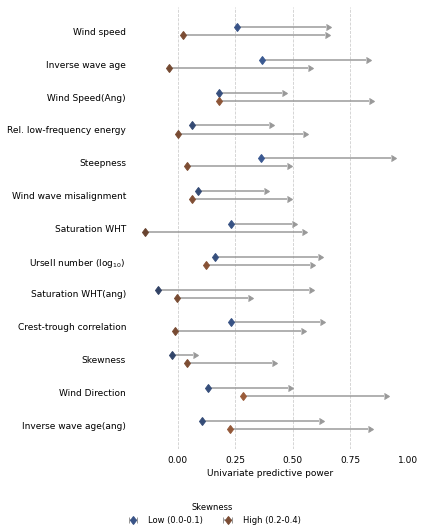

In [27]:

skew_bins = [(0.0,0.1),(0.2,0.4)]
#Z = df[['WSPD','inverse_wave_age_U10','inverse_wave_age','sea_state_30m_steepness']]
skew_p = []

for lower, upper in skew_bins:
    mask = (
        (X['sea_state_30m_skewness'] < upper) 
        & (X['sea_state_30m_skewness'] > lower)
    )
    skew_p.append((
        get_binned_p(
            X[mask],
            y_low[mask],
            priors[thresh_low],
            inflation_factor=100
        )
    ))




feature_subset = [ 
    'sea_state_30m_steepness',
    'inverse_wave_age',
    'inverse_wave_age_ang',  
]

plot_binned_p(
    skew_p[1], [f'P(CAI > {thresh_low})'], 
    features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.gca().get_legend().remove()
plt.suptitle('High skewness', y=0.9, x=0.55)
plt.subplots_adjust(top=0.6, bottom=-0.2)
plt.savefig('large-skew-crests.pdf')

plot_binned_p(
    skew_p[0], [f'P(CAI > {thresh_low})'], 
    features=feature_subset, plot_tayfun=False, fac=[1, 20]
)

plt.suptitle('Low skewness', y=1.3, x=0.55)
plt.subplots_adjust(top=1)
plt.savefig('small-skewness-crests.pdf', bbox_inches='tight')    






skew_labels = [f'{name} ({low}-{up})' for name, (low, up) in zip(('Low', 'High'), skew_bins)]

for label, p in zip(skew_labels, skew_p):
    for feature, vals in sorted(p.items(), key=lambda v: v[1]['pred_power_p95'][0], reverse=True):
        if vals['pred_power_p95'][0] > 0.1:
            print(label, feature, vals['pred_power_p95'][0])

plot_predictive_power(skew_p, skew_labels, legend_title='Skewness')
plt.savefig('predpower_skewness_posneg_crests.pdf', bbox_inches='tight') 


# Rayleigh distribution for relative wave heights

In [28]:
'''
import numpy as np
import matplotlib.pyplot as plt
#x=ai
#Label = rc('Rayleigh PDF : exp(AI^2/0.5)', usetex=True) 
# 
d = np.exp(-1*(x**2)/0.5)
x = np.linspace(0, 2.5 ,100000) 
fig = plt.figure()
plt.yscale('log')
plt.plot(x, d,label='Rayleigh PDF : exp(AI\u00b2/0.5)')
plt.xlabel('AI')
plt.ylabel('Probability')
plt.legend(loc='upper right')
plt.fill_between(x,d, where = (x >= 2) & (x <= 3),color = 'b')
plt.savefig('rayleigh.pdf', bbox_inches='tight')  
'''

"\nimport numpy as np\nimport matplotlib.pyplot as plt\n#x=ai\n#Label = rc('Rayleigh PDF : exp(AI^2/0.5)', usetex=True) \n# \nd = np.exp(-1*(x**2)/0.5)\nx = np.linspace(0, 2.5 ,100000) \nfig = plt.figure()\nplt.yscale('log')\nplt.plot(x, d,label='Rayleigh PDF : exp(AI²/0.5)')\nplt.xlabel('AI')\nplt.ylabel('Probability')\nplt.legend(loc='upper right')\nplt.fill_between(x,d, where = (x >= 2) & (x <= 3),color = 'b')\nplt.savefig('rayleigh.pdf', bbox_inches='tight')  \n"

# Effect of distance on the wind-fowd correlations

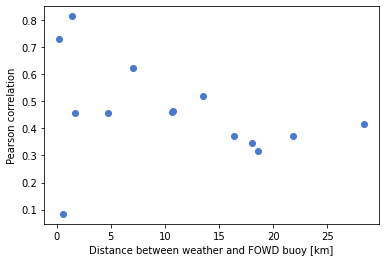

In [29]:

#id_list = ['107', '168', '171', '179', '185', '185', '227', '234','036','147','156','162','142']
#'sea_state_30m_significant_wave_height_spectral'
'''
corr_107 = df_107['inverse_wave_age'].corr(df_107['sea_state_30m_mean_period_spectral'])
corr_168 = df_168['inverse_wave_age'].corr(df_168['sea_state_30m_mean_period_spectral'])
corr_171 = df_171['inverse_wave_age'].corr(df_171['sea_state_30m_mean_period_spectral'])
corr_179 = df_179['inverse_wave_age'].corr(df_179['sea_state_30m_mean_period_spectral'])
corr_142 = df_142['inverse_wave_age'].corr(df_142['sea_state_30m_mean_period_spectral'])
corr_185 = df_185['inverse_wave_age'].corr(df_185['sea_state_30m_mean_period_spectral'])
corr_227 = df_227['inverse_wave_age'].corr(df_227['sea_state_30m_mean_period_spectral'])
corr_234 = df_234['inverse_wave_age'].corr(df_234['sea_state_30m_mean_period_spectral'])
corr_036 = df_036['inverse_wave_age'].corr(df_036['sea_state_30m_mean_period_spectral'])
corr_147 = df_147['inverse_wave_age'].corr(df_147['sea_state_30m_mean_period_spectral'])
corr_156 = df_156['inverse_wave_age'].corr(df_156['sea_state_30m_mean_period_spectral'])
corr_162 = df_162['inverse_wave_age'].corr(df_162['sea_state_30m_mean_period_spectral'])
corr_180 = df_180['inverse_wave_age'].corr(df_180['sea_state_30m_mean_period_spectral'])
corr_235 = df_235['inverse_wave_age'].corr(df_235['sea_state_30m_mean_period_spectral'])
corr_128 = df_128['inverse_wave_age'].corr(df_128['sea_state_30m_mean_period_spectral'])

corr_107 = df_107['inverse_wave_age'].corr(df_107['sea_state_30m_rel_energy_in_frequency_interval_2'])
corr_168 = df_168['inverse_wave_age'].corr(df_168['sea_state_30m_rel_energy_in_frequency_interval_2'])
corr_171 = df_171['inverse_wave_age'].corr(df_171['sea_state_30m_rel_energy_in_frequency_interval_2'])
corr_179 = df_179['inverse_wave_age'].corr(df_179['sea_state_30m_rel_energy_in_frequency_interval_2'])
corr_142 = df_142['inverse_wave_age'].corr(df_142['sea_state_30m_rel_energy_in_frequency_interval_2'])
corr_185 = df_185['inverse_wave_age'].corr(df_185['sea_state_30m_rel_energy_in_frequency_interval_2'])
corr_227 = df_227['inverse_wave_age'].corr(df_227['sea_state_30m_rel_energy_in_frequency_interval_2'])
corr_234 = df_234['inverse_wave_age'].corr(df_234['sea_state_30m_rel_energy_in_frequency_interval_2'])
corr_036 = df_036['inverse_wave_age'].corr(df_036['sea_state_30m_rel_energy_in_frequency_interval_2'])
corr_147 = df_147['inverse_wave_age'].corr(df_147['sea_state_30m_rel_energy_in_frequency_interval_2'])
corr_156 = df_156['inverse_wave_age'].corr(df_156['sea_state_30m_rel_energy_in_frequency_interval_2'])
corr_162 = df_162['inverse_wave_age'].corr(df_162['sea_state_30m_rel_energy_in_frequency_interval_2'])
corr_180 = df_180['inverse_wave_age'].corr(df_180['sea_state_30m_rel_energy_in_frequency_interval_2'])
corr_235 = df_235['inverse_wave_age'].corr(df_235['sea_state_30m_rel_energy_in_frequency_interval_2'])
corr_128 = df_128['inverse_wave_age'].corr(df_128['sea_state_30m_rel_energy_in_frequency_interval_2'])

'''
corr_107 = df_107['WSPD'].corr(df_107['sea_state_30m_significant_wave_height_spectral'])
corr_168 = df_168['WSPD'].corr(df_168['sea_state_30m_significant_wave_height_spectral'])
corr_171 = df_171['WSPD'].corr(df_171['sea_state_30m_significant_wave_height_spectral'])
corr_179 = df_179['WSPD'].corr(df_179['sea_state_30m_significant_wave_height_spectral'])
corr_142 = df_142['WSPD'].corr(df_142['sea_state_30m_significant_wave_height_spectral'])
corr_185 = df_185['WSPD'].corr(df_185['sea_state_30m_significant_wave_height_spectral'])
corr_227 = df_227['WSPD'].corr(df_227['sea_state_30m_significant_wave_height_spectral'])
corr_234 = df_234['WSPD'].corr(df_234['sea_state_30m_significant_wave_height_spectral'])
corr_036 = df_036['WSPD'].corr(df_036['sea_state_30m_significant_wave_height_spectral'])
corr_147 = df_147['WSPD'].corr(df_147['sea_state_30m_significant_wave_height_spectral'])
corr_156 = df_156['WSPD'].corr(df_156['sea_state_30m_significant_wave_height_spectral'])
corr_162 = df_162['WSPD'].corr(df_162['sea_state_30m_significant_wave_height_spectral'])
corr_180 = df_180['WSPD'].corr(df_180['sea_state_30m_significant_wave_height_spectral'])
corr_235 = df_235['WSPD'].corr(df_235['sea_state_30m_significant_wave_height_spectral'])
corr_128 = df_128['WSPD'].corr(df_128['sea_state_30m_significant_wave_height_spectral'])
#(0, 0.1),

corr_list = np.array([corr_036,corr_107,corr_128,corr_142,corr_147,corr_156,corr_162,corr_168,corr_171,corr_179,corr_180,corr_185,corr_227,corr_234,corr_235])
corr_list = pd.DataFrame(corr_list)
#id_list = pd.DataFrame(id_list)


scaler = pd.read_csv(r'C:/Users/yulii/Downloads/meta_data_wind_FOWD',sep=',',index_col=0)
d_list = scaler['Distance_kilometers']
#sand = corr_list.corr(d_list)
#print(sand)
x=d_list
y=corr_list
plt.scatter(x, y)
plt.xlabel('Distance between weather and FOWD buoy [km]')
plt.ylabel('Pearson correlation')
plt.savefig('cdstation.pdf')
plt.show()



# Stratifying on Steepness

peak (0.03-0.04) sea_state_30m_peak_ursell_number_log10 0.8179505673017772
peak (0.03-0.04) sea_state_30m_skewness 0.662502958660454
peak (0.03-0.04) inverse_wave_age 0.5567528957499489
peak (0.03-0.04) saturation_wave_height 0.2899161074659958
peak (0.03-0.04) inverse_wave_age_ang 0.23034172664942754
peak (0.03-0.04) WSPD 0.20883076889313457
peak (0.03-0.04) sea_state_30m_rel_energy_in_frequency_interval_2 0.12803853601830445
peak (0.03-0.04) sea_state_30m_crest_trough_correlation 0.11815502446435043
high (0.05-0.08) saturation_wave_height 0.4047951576678933
high (0.05-0.08) sea_state_30m_peak_ursell_number_log10 0.3006621609221451
high (0.05-0.08) inverse_wave_age 0.21124558568070093
high (0.05-0.08) sea_state_30m_crest_trough_correlation 0.18451009170905025
high (0.05-0.08) inverse_wave_age_ang 0.1414102443004808
high (0.05-0.08) WSPD_ang 0.12682421185873438
high (0.05-0.08) sea_state_30m_skewness 0.11910683228165748
high (0.05-0.08) WSPD 0.10344126629462519
low (0.0-0.03) sea_state

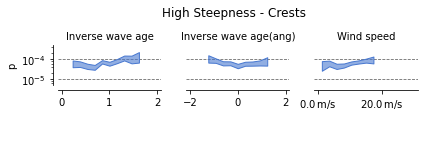

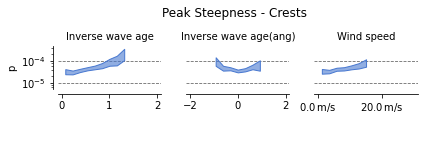

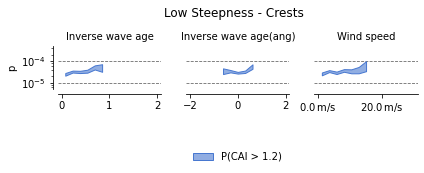

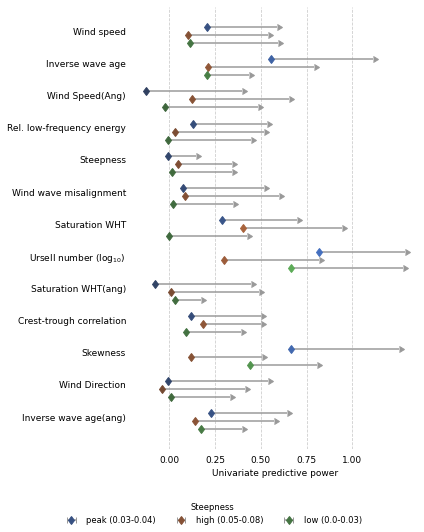

In [31]:
steep_bins = [(0.03, 0.04), (0.05, 0.08), (0.0, 0.03)]
#Z = df[['WSPD','inverse_wave_age_U10','inverse_wave_age','sea_state_30m_steepness']]
steep_p = []

for lower, upper in steep_bins:
    mask = (
        (X['sea_state_30m_steepness'] < upper) 
        & (X['sea_state_30m_steepness'] > lower)
    )
    steep_p.append((
        get_binned_p(
            X[mask],
            y_low[mask],
            priors[thresh_low],
            inflation_factor=100
        )
    ))






feature_subset = [
    'inverse_wave_age',
    'inverse_wave_age_ang',
    'WSPD',
]

plot_binned_p(
    steep_p[1], [f'P(CAI > {thresh_low})'],features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.gca().get_legend().remove()
plt.suptitle('High Steepness - Crests', y=0.9, x=0.55)
plt.subplots_adjust(top=0.6, bottom=-0.2)
plt.savefig('High steepness - beta- Crests.pdf')

plot_binned_p(
    steep_p[0], [f'P(CAI > {thresh_low})'], 
    features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.gca().get_legend().remove()
plt.suptitle('Peak Steepness - Crests', y=1.3, x=0.55)
plt.subplots_adjust(top=1)
plt.savefig('peak-Steepness - beta- Crests.pdf', bbox_inches='tight')  

plot_binned_p(
    steep_p[2], [f'P(CAI > {thresh_low})'], 
    features=feature_subset, plot_tayfun=False, fac=[1, 20]
)
plt.suptitle('Low Steepness - Crests', y=1.3, x=0.55)
plt.subplots_adjust(top=1)
plt.savefig('low-steepness - beta- Crests.pdf', bbox_inches='tight')    





steep_labels = [f'{name} ({low}-{up})' for name, (low, up) in zip(('peak', 'high', 'low'), steep_bins)]

for label, p in zip(steep_labels, steep_p):
    for feature, vals in sorted(p.items(), key=lambda v: v[1]['pred_power_p95'][0], reverse=True):
        if vals['pred_power_p95'][0] > 0.1:
            print(label, feature, vals['pred_power_p95'][0])

plot_predictive_power(steep_p, steep_labels, legend_title='Steepness')
plt.savefig('predpower_steep_crests.pdf', bbox_inches='tight') 